In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import scienceplots
import os

import numpy.typing as npt
from typing import Tuple
from tqdm.auto import tqdm

plt.style.use(['science', 'ieee', 'no-latex'])

/home/louis/anaconda3/envs/sim/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print(torch.cuda.is_available())

True


In [4]:
NA = 0.86
LAMBDA = 248
K = 2 * np.pi / LAMBDA
W = NA / LAMBDA
THRESHOLD = 0.5

target_path = './img_test/dense_line'
if not os.path.isdir(target_path):
	os.makedirs(target_path)

In [5]:
def generate_Ein(
	s: npt.NDArray,
	angle: int = 0,
	magnitude: int = 1
) -> npt.NDArray:
	angle = angle / 180 * np.pi
	return magnitude * np.exp(1j * K * s * np.sin(angle))

In [6]:
def freq_and_Eoutshift(
	s: npt.NDArray,
	E_out_unshift: npt.NDArray,
	Fs: int
) -> Tuple[npt.NDArray, npt.NDArray]:
	N = (np.shape(s)[0] - 1) // 2
	freq = Fs * np.arange(-N, N + 1) / (2 * N)
	E_out_shift = np.concatenate((E_out_unshift[N + 1:], E_out_unshift[:N + 1]))
	return freq, E_out_shift

In [7]:
# sampling rate
Fs_dense = 1000
# dense line space
s_dense_space = 2200
s_dense: npt.NDArray = np.linspace(
    -s_dense_space, s_dense_space,
    2 * s_dense_space * Fs_dense + 1,
    dtype=np.double
)

In [8]:
start_width, end_width = 0, 500
s_dense_multiple_width = np.linspace(
	start_width, 
	end_width, 
	100 * end_width + 1, 
	dtype=int
)
s_dense_measured_CD = np.zeros_like(s_dense_multiple_width)
angle, magnitude = 0, 1
for width in tqdm(s_dense_multiple_width):
	if width == 0:
		s_dense_measured_CD[s_dense_multiple_width == width] = 0
		continue
	# generate mask with different width
	s_dense_mask = np.zeros_like(s_dense, dtype=np.double)
	points = range(0, s_dense_space, 4 * width)
	for center in points:
		cond = np.abs(s_dense - center) <= width
		s_dense_mask[cond] = 1
		cond = np.abs(s_dense + center) <= width
		s_dense_mask[cond] = 1
	# generate Ein
	E_in = generate_Ein(s_dense, angle, magnitude)
	# Ein and mask
	torch_s_dense_mask = torch.from_numpy(s_dense_mask)
	torch_E_in = torch.from_numpy(E_in)
	torch_s_dense_mask = torch_s_dense_mask.to(torch.device("cuda"))
	torch_E_in = torch_E_in.to(torch.device("cuda"))
	torch_E_in_mask = torch_s_dense_mask * torch_E_in
	torch_E_in_mask = torch_E_in_mask.to(torch.device("cuda"))
	torch_E_out_unshift: torch.Tensor = torch.fft.fft(torch_E_in_mask)
	E_out_unshift = torch_E_out_unshift.to(torch.device("cpu")).numpy()
	# get freq, E_out_shift
	freq, E_out_shift = freq_and_Eoutshift(
		s_dense, 
		E_out_unshift, 
		Fs_dense
	)
	E_out_shift_after_exit_pupil = np.where(
		np.abs(freq) <= W, E_out_shift, 0
	)
	torch_E_out_shift_after_exit_pupil = torch.from_numpy(E_out_shift_after_exit_pupil)
	torch_E_out_shift_after_exit_pupil = torch_E_out_shift_after_exit_pupil.to('cuda')
	torch_E_output: torch.Tensor = torch.fft.ifft(torch_E_out_shift_after_exit_pupil)
	E_output = torch_E_output.to(torch.device("cpu")).numpy()
	I = np.multiply(np.abs(E_output), np.abs(E_output))
	# if CD can be measured
	try:
		positive = s_dense[s_dense > 0]
		I_positive = I[s_dense > 0]
		freq_right = np.min(positive[I_positive < THRESHOLD])
		negative = s_dense[s_dense < 0]
		I_negative = I[s_dense < 0]
		freq_left = np.max(negative[I_negative < THRESHOLD])
		CD = freq_right - freq_left
	except ValueError:
		CD = 0
	s_dense_measured_CD[s_dense_multiple_width == width] = CD

100%|██████████| 50001/50001 [5:27:48<00:00,  2.54it/s]  


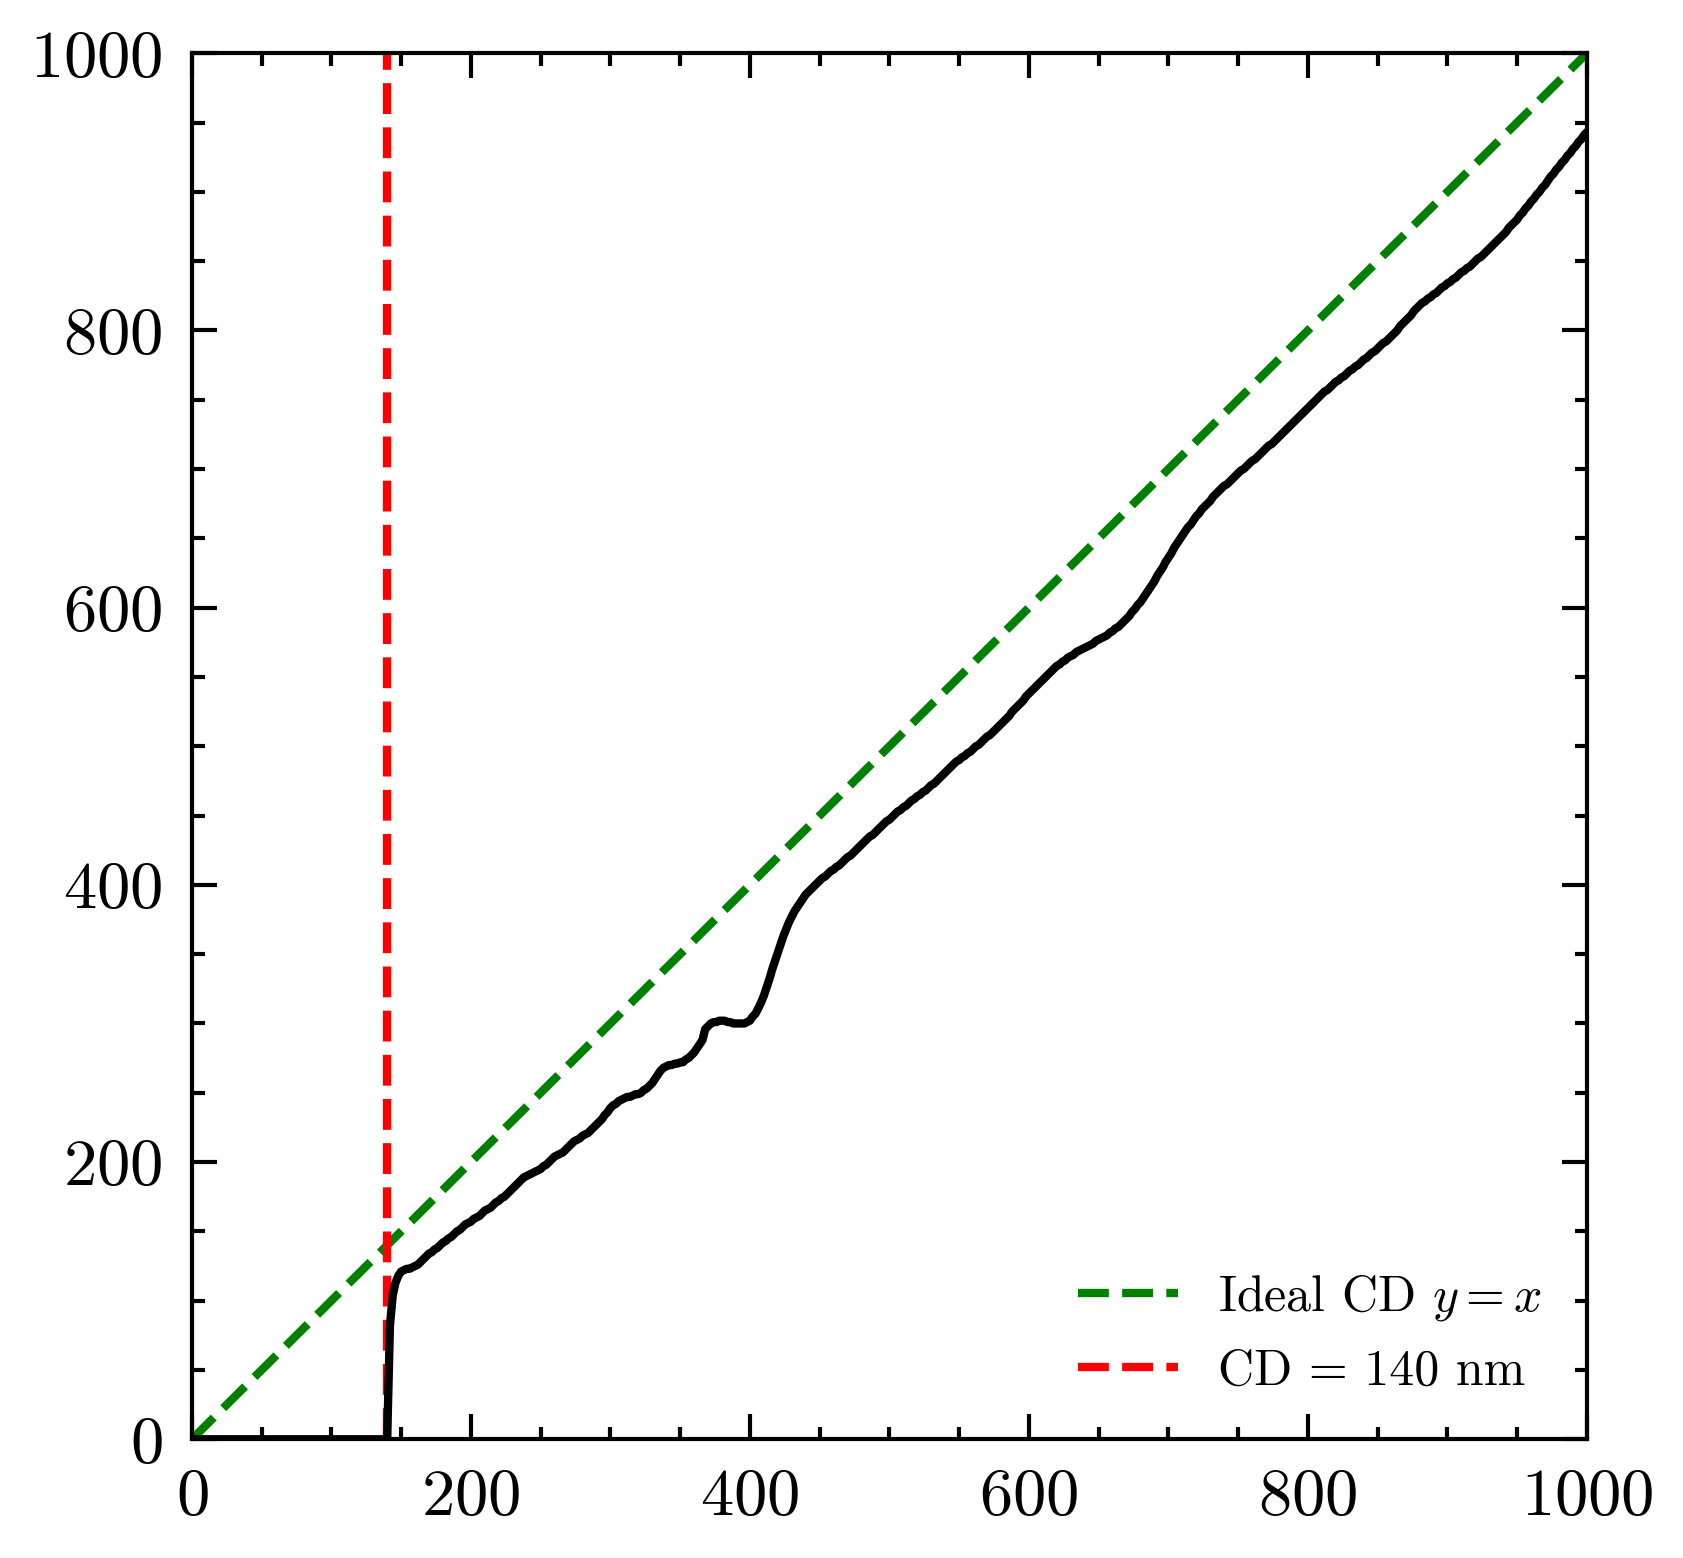

In [9]:
# plot CD and CD_measured under different CD condition
np_func = np.vectorize(lambda x: x * 2)
s_dense_theoretical_CD = np_func(s_dense_multiple_width)
m, M = min(s_dense_theoretical_CD), max(s_dense_theoretical_CD)
x_not_zero_max = np.max(s_dense_theoretical_CD[s_dense_measured_CD == 0])
plt.figure(figsize=(3, 3))
plt.xlim(m, M)
plt.ylim(m, M)
plt.axline(
    xy1=(0, 0), xy2=(1000, 1000), 
    color='g', linestyle='--',
    label=r'Ideal CD $y=x$'    
)
plt.axvline(
    x=x_not_zero_max, 
    ymin=m, ymax=M, 
    color='r', linestyle='--',
    label=f'CD = {x_not_zero_max} nm'
)
plt.legend(fontsize=6)
plt.plot(s_dense_theoretical_CD, s_dense_measured_CD)
plt.savefig(f'{target_path}/dense_line_comparison_under_different_CD.png')